# Overview of the project
### One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.
#### In this recruiting competition, we are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and the goal is to project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.

<img src="walmart.jpg" align="left">
<img src="markdowns.png" align="right">

# Importing the Required Libraries

In [1]:
#For Data Analysis
import pandas as pd
import numpy as np
from numpy import *

In [2]:
#For date time functions
from datetime import datetime
from datetime import timedelta

In [3]:
#For statistics 
import math
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

In [4]:
#For Data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#For Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse

In [6]:
#For Debugging
import gc
import time
import warnings
import os

In [7]:
#Performance check
from sklearn.metrics import mean_squared_error

# Reading the data

In [8]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
features=pd.read_csv('features.csv')
train['Type']='Train'
test['Type']='Test'

### Train data
This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week

In [9]:
#Having a look at the data
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type
0,1,1,2010-02-05,24924.50,False,Train
1,1,1,2010-02-12,46039.49,True,Train
2,1,1,2010-02-19,41595.55,False,Train
3,1,1,2010-02-26,19403.54,False,Train
4,1,1,2010-03-05,21827.90,False,Train


In [10]:
test.head()

,Store,Dept,Date,IsHoliday,Type
0,1,1,2012-11-02,False,Test
1,1,1,2012-11-09,False,Test
2,1,1,2012-11-16,False,Test
3,1,1,2012-11-23,True,Test
4,1,1,2012-11-30,False,Test


### Features.csv
Store - the store number.
Date - the week.
Temperature - average temperature in the region.
Fuel_Price - cost of fuel in the region.
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
CPI - the consumer price index.
Unemployment - the unemployment rate.
IsHoliday - whether the week is a special holiday week.

In [11]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## Data Cleaning

In [12]:
#Check for null values
train.isnull().any()

Store           False
Dept            False
Date            False
Weekly_Sales    False
IsHoliday       False
Type            False
dtype: bool

In [13]:
test.isnull().any()

Store        False
Dept         False
Date         False
IsHoliday    False
Type         False
dtype: bool

In [14]:
features.isnull().any()

Store           False
Date            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI              True
Unemployment     True
IsHoliday       False
dtype: bool

### There are null values present in the Markdown, CPI and Unemployment columns of the features data frame. Lets check howmany are there

In [15]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

### Combining the train and test data. By doing this we will have enough data to perform Feature Engineering

In [16]:
train.shape, test.shape, features.shape

((421570, 6), (115064, 5), (8190, 12))

In [17]:
df=pd.concat([features,train,test],axis=0)

C:\Users\Devansh\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [18]:
df.shape

(544824, 15)

In [19]:
df.head(8191)

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store,Temperature,Type,Unemployment,Weekly_Sales
0,211.096358,2010-02-05,NaN,2.572,False,NaN,NaN,NaN,NaN,NaN,1,42.31,NaN,8.106,NaN
1,211.242170,2010-02-12,NaN,2.548,True,NaN,NaN,NaN,NaN,NaN,1,38.51,NaN,8.106,NaN
2,211.289143,2010-02-19,NaN,2.514,False,NaN,NaN,NaN,NaN,NaN,1,39.93,NaN,8.106,NaN
3,211.319643,2010-02-26,NaN,2.561,False,NaN,NaN,NaN,NaN,NaN,1,46.63,NaN,8.106,NaN
4,211.350143,2010-03-05,NaN,2.625,False,NaN,NaN,NaN,NaN,NaN,1,46.50,NaN,8.106,NaN
5,211.380643,2010-03-12,NaN,2.667,False,NaN,NaN,NaN,NaN,NaN,1,57.79,NaN,8.106,NaN
6,211.215635,2010-03-19,NaN,2.720,False,NaN,NaN,NaN,NaN,NaN,1,54.58,NaN,8.106,NaN
7,211.018042,2010-03-26,NaN,2.732,False,NaN,NaN,NaN,NaN,NaN,1,51.45,NaN,8.106,NaN
8,210.820450,2010-04-02,NaN,2.719,False,NaN,NaN,NaN,NaN,NaN,1,62.27,NaN,7.808,NaN
9,210.622857,2010-04-09,NaN,2.770,False,NaN,NaN,NaN,NaN,NaN,1,65.86,NaN,7.808,NaN


### NaN for markdown means that there was no markdown event for that date. So we can replace that with 0 indicating no mark down

In [20]:
#First we check whether what happens when we replace NA's with 0
df.fillna(0).head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store,Temperature,Type,Unemployment,Weekly_Sales
0,211.096358,2010-02-05,0.0,2.572,False,0.0,0.0,0.0,0.0,0.0,1,42.31,0,8.106,0.0
1,211.242170,2010-02-12,0.0,2.548,True,0.0,0.0,0.0,0.0,0.0,1,38.51,0,8.106,0.0
2,211.289143,2010-02-19,0.0,2.514,False,0.0,0.0,0.0,0.0,0.0,1,39.93,0,8.106,0.0
3,211.319643,2010-02-26,0.0,2.561,False,0.0,0.0,0.0,0.0,0.0,1,46.63,0,8.106,0.0
4,211.350143,2010-03-05,0.0,2.625,False,0.0,0.0,0.0,0.0,0.0,1,46.50,0,8.106,0.0


In [21]:
#Removing rows with null values in all columns
df.dropna(axis=0, how="all", inplace=True)
#Removing all rows with null values in all rows
df.dropna(axis=1, how="all", inplace=True)

In [22]:
df.shape

(544824, 15)

In [23]:
#Fill missing values with 0
df_fill=df.fillna(0)

In [24]:
df_fill.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store,Temperature,Type,Unemployment,Weekly_Sales
0,211.096358,2010-02-05,0.0,2.572,False,0.0,0.0,0.0,0.0,0.0,1,42.31,0,8.106,0.0
1,211.242170,2010-02-12,0.0,2.548,True,0.0,0.0,0.0,0.0,0.0,1,38.51,0,8.106,0.0
2,211.289143,2010-02-19,0.0,2.514,False,0.0,0.0,0.0,0.0,0.0,1,39.93,0,8.106,0.0
3,211.319643,2010-02-26,0.0,2.561,False,0.0,0.0,0.0,0.0,0.0,1,46.63,0,8.106,0.0
4,211.350143,2010-03-05,0.0,2.625,False,0.0,0.0,0.0,0.0,0.0,1,46.50,0,8.106,0.0


In [25]:
df_fill.isna().sum()

CPI             0
Date            0
Dept            0
Fuel_Price      0
IsHoliday       0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
Store           0
Temperature     0
Type            0
Unemployment    0
Weekly_Sales    0
dtype: int64

In [26]:
df_fill.describe()

,CPI,Dept,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store,Temperature,Unemployment,Weekly_Sales
count,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000
mean,2.407318,43.611708,0.051200,52.043454,18.143804,11.672103,20.936541,30.717216,22.220517,0.892265,0.109252,12365.863081
std,20.770490,30.772363,0.417807,999.040140,689.572588,929.208371,601.458362,1182.693075,12.793920,7.576901,0.944640,21066.981451
min,0.000000,0.000000,0.000000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,1.000000,-7.290000,0.000000,-4988.940000
25%,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,25.377500
50%,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,3917.305000
75%,0.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000,15203.442500
max,228.976456,99.000000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,45.000000,101.950000,14.313000,693099.360000


In [27]:
df_Temp_mean=df.Temperature.fillna(df['Temperature'].mean())

In [28]:
df_Unemployment_mean=df.Unemployment.fillna(df['Unemployment'].mean())

In [29]:
df_Weekly_Sales_mean=df.Weekly_Sales.fillna(df['Weekly_Sales'].mean())

In [30]:
df_fill['Weekly_Sales_mean']=df_Weekly_Sales_mean
df_fill['Unemployment_mean']=df_Unemployment_mean
df_fill['Temp_mean']=df_Temp_mean

In [31]:
df_fill.describe()
#Statistics for Weekly Sales, Unemployment and Temperature confirm that we have done the missing values imputation with mean

,CPI,Dept,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store,Temperature,Unemployment,Weekly_Sales,Weekly_Sales_mean,Unemployment_mean,Temp_mean
count,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000
mean,2.407318,43.611708,0.051200,52.043454,18.143804,11.672103,20.936541,30.717216,22.220517,0.892265,0.109252,12365.863081,15981.258123,7.826821,59.356198
std,20.770490,30.772363,0.417807,999.040140,689.572588,929.208371,601.458362,1182.693075,12.793920,7.576901,0.944640,21066.981451,19977.741247,0.221777,2.289983
min,0.000000,0.000000,0.000000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,1.000000,-7.290000,0.000000,-4988.940000,-4988.940000,3.684000,-7.290000
25%,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,25.377500,3330.647500,7.826821,59.356198
50%,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,3917.305000,13479.800000,7.826821,59.356198
75%,0.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000,15203.442500,15981.258123,7.826821,59.356198
max,228.976456,99.000000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,45.000000,101.950000,14.313000,693099.360000,693099.360000,14.313000,101.950000


In [32]:
df_fill.tail(50)

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store,Temperature,Type,Unemployment,Weekly_Sales,Weekly_Sales_mean,Unemployment_mean,Temp_mean
115014,0.0,2013-05-17,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115015,0.0,2013-05-24,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115016,0.0,2013-05-31,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115017,0.0,2013-06-07,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115018,0.0,2013-06-14,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115019,0.0,2013-06-21,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115020,0.0,2013-06-28,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115021,0.0,2013-07-05,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115022,0.0,2013-07-12,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198
115023,0.0,2013-07-19,97.0,0.0,False,0.0,0.0,0.0,0.0,0.0,45,0.0,Test,0.0,0.0,15981.258123,7.826821,59.356198


## Data Visualization

### Weekly Sales by Department (1-99)

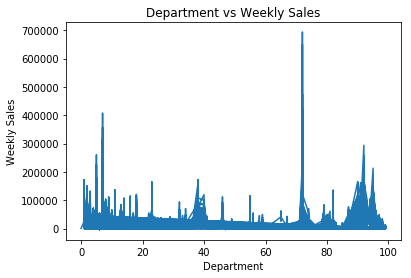

In [33]:
import matplotlib.pyplot as plt
#Weekly sales by Department
x=df_fill['Dept']
y=df_fill['Weekly_Sales']
plt.title("Department vs Weekly Sales")
plt.xlabel("Department")
plt.ylabel("Weekly Sales")
plt.plot(x,y)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


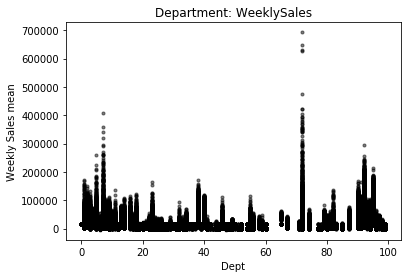

In [34]:
#Imputed Weekly Sales by Department
x= df_fill['Dept'].values
y= df_fill['Weekly_Sales_mean'].values
colors = (0,0,0)
area= np.pi*3
plt.scatter(x,y,s=area,c=colors,alpha=0.5)
plt.title("Department: WeeklySales")
plt.xlabel('Dept')
plt.ylabel('Weekly Sales mean')
plt.show()

### Weekly sales by Store (1-45)

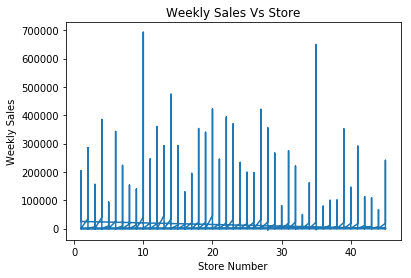

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


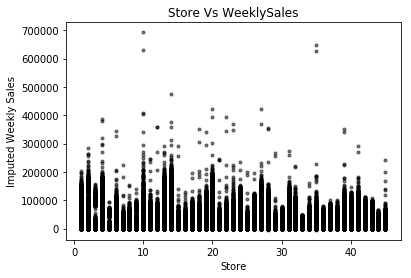

In [35]:
x=df_fill['Store']
y=df_fill['Weekly_Sales']
plt.title('Weekly Sales Vs Store')
plt.xlabel('Store Number')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()


x=df_fill['Store'].values   #.values command makes an array
y=df_fill['Weekly_Sales_mean'].values
plt.scatter(x,y,s=np.pi*3,c=(0,0,0),alpha=0.5)
plt.title("Store Vs WeeklySales")
plt.xlabel('Store')
plt.ylabel('Imputed Weekly Sales')
plt.show()

### Weekly Sales by Date


### Lets first make the year and week columns for a better understanding of sales

In [36]:
df_fill.Date=pd.to_datetime(df_fill.Date)
df_fill['Year']=df_fill.Date.dt.year
df_fill['Week']=df_fill.Date.dt.week


In [37]:
df_fill['Month']=df_fill.Date.dt.month

In [38]:
df_fill.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Temperature,Type,Unemployment,Weekly_Sales,Weekly_Sales_mean,Unemployment_mean,Temp_mean,Year,Week,Month
0,211.096358,2010-02-05,0.0,2.572,False,0.0,0.0,0.0,0.0,0.0,...,42.31,0,8.106,0.0,15981.258123,8.106,42.31,2010,5,2
1,211.242170,2010-02-12,0.0,2.548,True,0.0,0.0,0.0,0.0,0.0,...,38.51,0,8.106,0.0,15981.258123,8.106,38.51,2010,6,2
2,211.289143,2010-02-19,0.0,2.514,False,0.0,0.0,0.0,0.0,0.0,...,39.93,0,8.106,0.0,15981.258123,8.106,39.93,2010,7,2
3,211.319643,2010-02-26,0.0,2.561,False,0.0,0.0,0.0,0.0,0.0,...,46.63,0,8.106,0.0,15981.258123,8.106,46.63,2010,8,2
4,211.350143,2010-03-05,0.0,2.625,False,0.0,0.0,0.0,0.0,0.0,...,46.50,0,8.106,0.0,15981.258123,8.106,46.50,2010,9,3


### Yearwise, Monthwise and week-wise sales

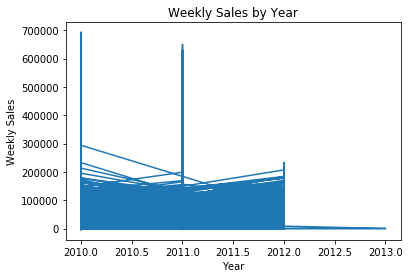

In [39]:
x=df_fill['Year']
y=df_fill['Weekly_Sales']
plt.title('Weekly Sales by Year')
plt.xlabel('Year')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

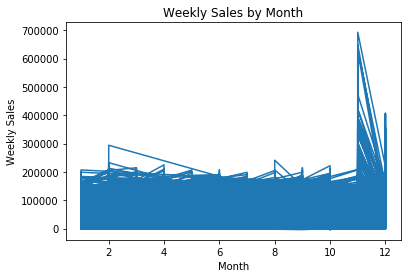

In [40]:
x=df_fill['Month']
y=df_fill['Weekly_Sales']
plt.title('Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

### There is a clear depiction of shoot in sales for holidays like thanksgiving, christmas and new year

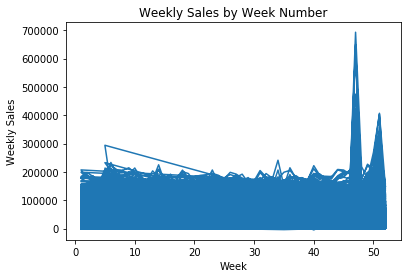

In [41]:
x=df_fill['Week']
y=df_fill['Weekly_Sales']
plt.title('Weekly Sales by Week Number')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

### Let's now analyse sales when there is a holiday versus when there is not

In [42]:
#Lets check how many Holidays are there
df_fill['IsHoliday'].value_counts()

False    505650
True      39174
Name: IsHoliday, dtype: int64

In [43]:
#Converting true or false to 0 and 1
df_fill['IsHoliday01'] = df_fill['IsHoliday'].apply(lambda x: '1' if x == True else '0')

In [44]:
df_fill.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Type,Unemployment,Weekly_Sales,Weekly_Sales_mean,Unemployment_mean,Temp_mean,Year,Week,Month,IsHoliday01
0,211.096358,2010-02-05,0.0,2.572,False,0.0,0.0,0.0,0.0,0.0,...,0,8.106,0.0,15981.258123,8.106,42.31,2010,5,2,0
1,211.242170,2010-02-12,0.0,2.548,True,0.0,0.0,0.0,0.0,0.0,...,0,8.106,0.0,15981.258123,8.106,38.51,2010,6,2,1
2,211.289143,2010-02-19,0.0,2.514,False,0.0,0.0,0.0,0.0,0.0,...,0,8.106,0.0,15981.258123,8.106,39.93,2010,7,2,0
3,211.319643,2010-02-26,0.0,2.561,False,0.0,0.0,0.0,0.0,0.0,...,0,8.106,0.0,15981.258123,8.106,46.63,2010,8,2,0
4,211.350143,2010-03-05,0.0,2.625,False,0.0,0.0,0.0,0.0,0.0,...,0,8.106,0.0,15981.258123,8.106,46.50,2010,9,3,0


C:\Users\Devansh\Anaconda2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


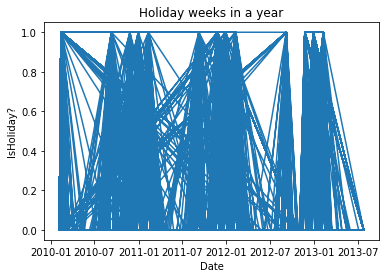

In [45]:
x=df_fill['Date']
y=df_fill['IsHoliday']
plt.title('Holiday weeks in a year')
plt.xlabel('Date')
plt.ylabel('IsHoliday?')
plt.plot(x,y)
plt.show()

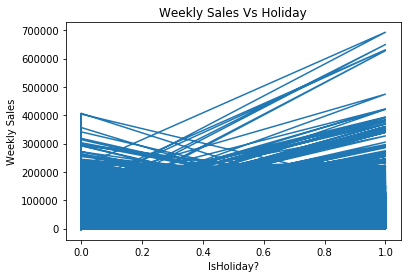

In [46]:
x=df_fill['IsHoliday']
y=df_fill['Weekly_Sales']
plt.title('Weekly Sales Vs Holiday')
plt.xlabel('IsHoliday?')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

### Visualizing the effect of markdown events on the weekly sales

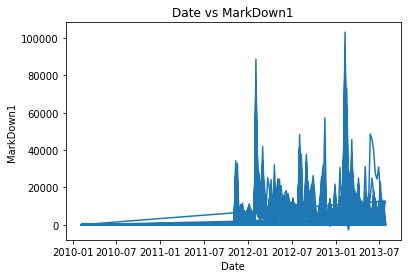

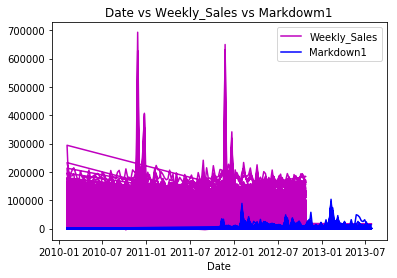

In [47]:
y1=df_fill['MarkDown1']
x=df_fill['Date']
plt.title("Date vs MarkDown1")
plt.xlabel("Date")
plt.ylabel("MarkDown1")
plt.plot(x,y1)
plt.show()

y1=df_fill['MarkDown1']
y2=df_fill['Weekly_Sales_mean']
x=df_fill['Date']
plt.plot(x,y2,c='m',label='Weekly_Sales')
plt.plot(x,y1,c='b',label='Markdown1')
plt.title("Date vs Weekly_Sales vs Markdowm1")
plt.xlabel("Date")
plt.legend()
plt.show()

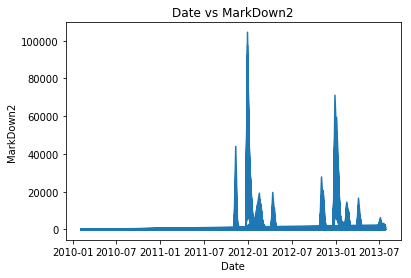

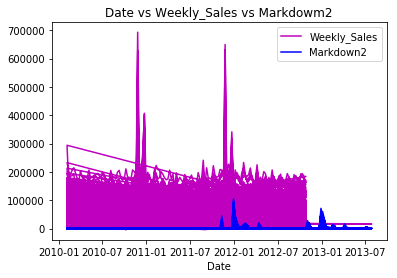

In [48]:
y1=df_fill['MarkDown2']
x=df_fill['Date']
plt.title("Date vs MarkDown2")
plt.xlabel("Date")
plt.ylabel("MarkDown2")
plt.plot(x,y1)
plt.show()

y1=df_fill['MarkDown2']
y2=df_fill['Weekly_Sales_mean']
x=df_fill['Date']
plt.plot(x,y2,c='m',label='Weekly_Sales')
plt.plot(x,y1,c='b',label='Markdown2')
plt.title("Date vs Weekly_Sales vs Markdowm2")
plt.xlabel("Date")
plt.legend()
plt.show()

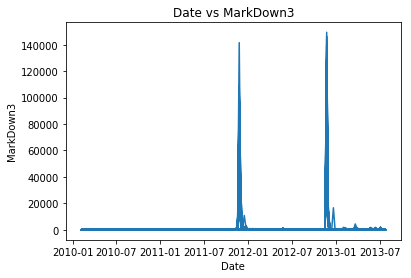

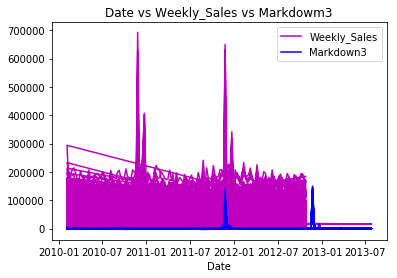

In [49]:
y1=df_fill['MarkDown3']
x=df_fill['Date']
plt.title("Date vs MarkDown3")
plt.xlabel("Date")
plt.ylabel("MarkDown3")
plt.plot(x,y1)
plt.show()

y1=df_fill['MarkDown3']
y2=df_fill['Weekly_Sales_mean']
x=df_fill['Date']
plt.plot(x,y2,c='m',label='Weekly_Sales')
plt.plot(x,y1,c='b',label='Markdown3')
plt.title("Date vs Weekly_Sales vs Markdowm3")
plt.xlabel("Date")
plt.legend()
plt.show()

### Markdown 3 seems to be very effective as compared to other markdown events

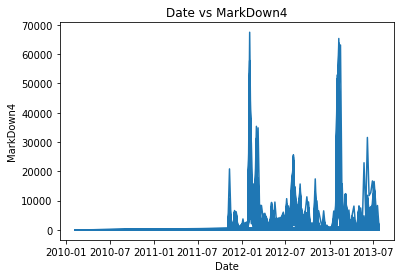

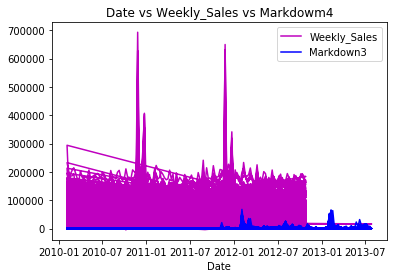

In [50]:
y1=df_fill['MarkDown4']
x=df_fill['Date']
plt.title("Date vs MarkDown4")
plt.xlabel("Date")
plt.ylabel("MarkDown4")
plt.plot(x,y1)
plt.show()

y1=df_fill['MarkDown4']
y2=df_fill['Weekly_Sales_mean']
x=df_fill['Date']
plt.plot(x,y2,c='m',label='Weekly_Sales')
plt.plot(x,y1,c='b',label='Markdown3')
plt.title("Date vs Weekly_Sales vs Markdowm4")
plt.xlabel("Date")
plt.legend()
plt.show()

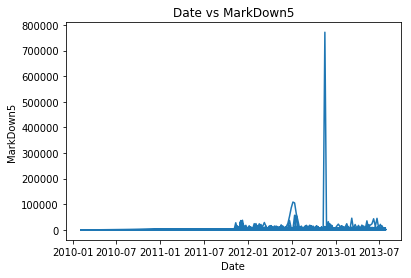

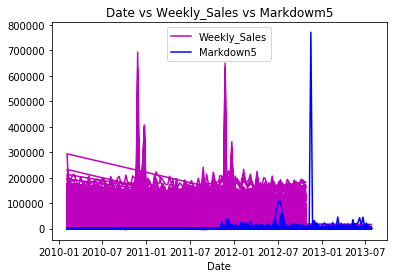

In [51]:
y1=df_fill['MarkDown5']
x=df_fill['Date']
plt.title("Date vs MarkDown5")
plt.xlabel("Date")
plt.ylabel("MarkDown5")
plt.plot(x,y1)
plt.show()


y1=df_fill['MarkDown5']
y2=df_fill['Weekly_Sales_mean']
x=df_fill['Date']
plt.plot(x,y2,c='m',label='Weekly_Sales')
plt.plot(x,y1,c='b',label='Markdown5')
plt.title("Date vs Weekly_Sales vs Markdowm5")
plt.xlabel("Date")
plt.legend()
plt.show()

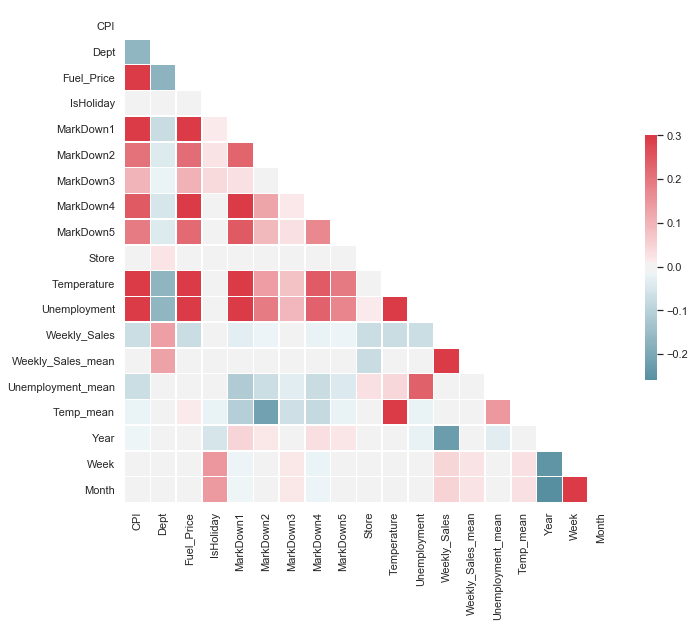

In [52]:
#Computing the correlation matrix to identify the relations between the variables
sns.set(style="white")

corr = df_fill.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Department - Weekly sales are more for the higher departments.
#### Fuel price - If the Fuel Price in the area is cheap, more customers will travel to the Store for shopping, But still, that has a very less correlation
#### CPI - If there is inflation, Cost of goods will rise which causes CPI to increase. This will cause a reduction in sales. It's obvious. But again, This doesn't have much correlation.
#### For a lesser store number, the weekly sales are higher.
#### Unemployment, Temperature is less? Sales are higher. (Not much correlation)

# HOLIDAY SEASON SALES
#### Let's have a look at Outliers, Are they during holidays? 
#### If yes than Ok. If no then they're false values

<img src='holiday.jpg' align="left">
<img src="markdowns.png" align="right">

In [53]:
df_fill.loc[df_fill['Weekly_Sales_mean'] >300000]

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Type,Unemployment,Weekly_Sales,Weekly_Sales_mean,Unemployment_mean,Temp_mean,Year,Week,Month,IsHoliday01
30474,0.0,2011-12-23,7.0,0.0,False,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,318422.01,318422.01,7.826821,59.356198,2011,51,12,0
37201,0.0,2010-11-26,72.0,0.0,True,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,381072.11,381072.11,7.826821,59.356198,2010,47,11,1
37253,0.0,2011-11-25,72.0,0.0,True,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,385051.04,385051.04,7.826821,59.356198,2011,47,11,1
56417,0.0,2010-11-26,72.0,0.0,True,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,342578.65,342578.65,7.826821,59.356198,2010,47,11,1
56469,0.0,2011-11-25,72.0,0.0,True,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,326866.60,326866.60,7.826821,59.356198,2011,47,11,1
88428,0.0,2010-12-24,7.0,0.0,False,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,406988.63,406988.63,7.826821,59.356198,2010,51,12,0
88480,0.0,2011-12-23,7.0,0.0,False,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,341308.00,341308.00,7.826821,59.356198,2011,51,12,0
95373,0.0,2010-11-26,72.0,0.0,True,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,693099.36,693099.36,7.826821,59.356198,2010,47,11,1
95377,0.0,2010-12-24,72.0,0.0,False,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,404245.03,404245.03,7.826821,59.356198,2010,51,12,0
95425,0.0,2011-11-25,72.0,0.0,True,0.0,0.0,0.0,0.0,0.0,...,Train,0.0,630999.19,630999.19,7.826821,59.356198,2011,47,11,1


## Merry Christmas, Happy Thanksgiving, Happy New Year.

In [54]:
#Examining the dates when the sales shoot up
df_fill.loc[df_fill['Weekly_Sales_mean'] >240000,"Date"].value_counts()

2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2011-08-26     1
2010-02-05     1
Name: Date, dtype: int64

## It seems that Holiday seasons affect the Walmart sales alot. So we create the necessary dummy variables to easily compare the categorical data with the numerical data

In [55]:
df_fill = df_fill.assign(md1_present = df_fill.MarkDown1.notnull())
df_fill = df_fill.assign(md2_present = df_fill.MarkDown2.notnull())
df_fill = df_fill.assign(md3_present = df_fill.MarkDown3.notnull())
df_fill = df_fill.assign(md4_present = df_fill.MarkDown4.notnull())
df_fill = df_fill.assign(md5_present = df_fill.MarkDown5.notnull())

In [56]:
df_fill['Store']='Store_' + df_fill['Store'].map(str)
df_fill['Dept']='Dept_' + df_fill['Dept'].map(str)
df_fill['IsHoliday']='IsHoliday_' + df_fill['IsHoliday'].map(str)
df_fill.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Temp_mean,Year,Week,Month,IsHoliday01,md1_present,md2_present,md3_present,md4_present,md5_present
0,211.096358,2010-02-05,Dept_0.0,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,42.31,2010,5,2,0,True,True,True,True,True
1,211.242170,2010-02-12,Dept_0.0,2.548,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,...,38.51,2010,6,2,1,True,True,True,True,True
2,211.289143,2010-02-19,Dept_0.0,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,39.93,2010,7,2,0,True,True,True,True,True
3,211.319643,2010-02-26,Dept_0.0,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,46.63,2010,8,2,0,True,True,True,True,True
4,211.350143,2010-03-05,Dept_0.0,2.625,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,46.50,2010,9,3,0,True,True,True,True,True


In [57]:
#Creating dummy variables now for store, department and holiday
store_dummies = pd.get_dummies(df_fill['Store'])
dept_dummies = pd.get_dummies(df_fill['Dept'])
holiday_dummies = pd.get_dummies(df_fill['IsHoliday'])

In [58]:
#Month also has a nice correlation so creating a dummy variable for month
df_fill['Month'] = 'Month_' + df_fill['Month'].map(str)

In [59]:
Month_dummies = pd.get_dummies(df_fill['Month'] )

In [60]:
df_fill['Black_Friday']=np.where((df_fill['Date']==datetime(2010, 11, 26).date()) | (df_fill['Date']==datetime(2011,11,25).date()), 'yes', 'no')
print((len(df_fill.loc[df_fill['Black_Friday'] == 'yes'])/len(df_fill))*100," % of rows are Black Friday")

C:\Users\Devansh\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


1.1102668017561634  % of rows are Black Friday


In [61]:
df_fill['Pre_christmas']=np.where((df_fill['Date']==datetime(2010, 12, 23).date()) | (df_fill['Date']==datetime(2010,12,24).date()) | (df_fill['Date']==datetime(2011, 12, 23).date()) | (df_fill['Date']==datetime(2011,12,24).date()), 'yes', 'no')
print((len(df_fill.loc[df_fill['Pre_christmas'] == 'yes'])/len(df_fill))*100," % of rows are Pre Christmas")

C:\Users\Devansh\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


1.1146718940428468  % of rows are Pre Christmas


In [62]:
#Creating dummies for Black friday and pre christmas
df_fill['Black_Friday'] = 'Black_Friday_' + df_fill['Black_Friday'].map(str)
df_fill['Pre_christmas'] = 'Pre_christmas_' + df_fill['Pre_christmas'].map(str)
Black_Friday_dummies = pd.get_dummies(df_fill['Black_Friday'] )
Pre_christmas_dummies = pd.get_dummies(df_fill['Pre_christmas'] )

In [63]:
df_fill.head(1000)

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Week,Month,IsHoliday01,md1_present,md2_present,md3_present,md4_present,md5_present,Black_Friday,Pre_christmas
0,211.096358,2010-02-05,Dept_0.0,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,5,Month_2,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
1,211.242170,2010-02-12,Dept_0.0,2.548,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,...,6,Month_2,1,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
2,211.289143,2010-02-19,Dept_0.0,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,7,Month_2,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
3,211.319643,2010-02-26,Dept_0.0,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,8,Month_2,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
4,211.350143,2010-03-05,Dept_0.0,2.625,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,9,Month_3,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
5,211.380643,2010-03-12,Dept_0.0,2.667,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,10,Month_3,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
6,211.215635,2010-03-19,Dept_0.0,2.720,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,11,Month_3,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
7,211.018042,2010-03-26,Dept_0.0,2.732,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,12,Month_3,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
8,210.820450,2010-04-02,Dept_0.0,2.719,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,13,Month_4,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no
9,210.622857,2010-04-09,Dept_0.0,2.770,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,14,Month_4,0,True,True,True,True,True,Black_Friday_no,Pre_christmas_no


In [64]:
#Creating dummies for the month
df_fill['Month_Year'] = [date.month for date in df_fill['Date']]
df_fill['Month_Year'] = df_fill['Month_Year'].map(str)
Month_dummies = pd.get_dummies(df_fill['Month_Year'] )

In [65]:
Month_dummies.head()

,1,10,11,12,2,3,4,5,6,7,8,9
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0


In [66]:
#Add dummies to the data frame now
df_fill = pd.concat([df_fill,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies],axis=1)

### Creating a data frame with average per store and department

In [67]:
medians = pd.DataFrame({'Median Sales' :df_fill.loc[df_fill['Type']=='Train'].groupby(by=['Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()

In [68]:
medians.head(10)

,Dept,Store,Month,IsHoliday,Median Sales
0,Dept_1.0,Store_1,Month_1,IsHoliday_False,17350.585
1,Dept_1.0,Store_1,Month_10,IsHoliday_False,23388.030
2,Dept_1.0,Store_1,Month_11,IsHoliday_False,19551.115
3,Dept_1.0,Store_1,Month_11,IsHoliday_True,19865.770
4,Dept_1.0,Store_1,Month_12,IsHoliday_False,39109.390
5,Dept_1.0,Store_1,Month_12,IsHoliday_True,21237.730
6,Dept_1.0,Store_1,Month_2,IsHoliday_False,23510.490
7,Dept_1.0,Store_1,Month_2,IsHoliday_True,37887.170
8,Dept_1.0,Store_1,Month_3,IsHoliday_False,21280.400
9,Dept_1.0,Store_1,Month_4,IsHoliday_False,26318.080


In [69]:
#Merge this data frame to the main data frame
df_fill = df_fill.merge(medians, how = 'outer', on = ['Dept','Store','Month','IsHoliday'])

In [70]:
df_fill.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday,Pre_christmas,Month_Year,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales
0,211.096358,2010-02-05,Dept_0.0,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,2,1,0,1,0,1,0,NaN
1,211.289143,2010-02-19,Dept_0.0,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,2,1,0,1,0,1,0,NaN
2,211.319643,2010-02-26,Dept_0.0,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,2,1,0,1,0,1,0,NaN
3,212.566881,2011-02-04,Dept_0.0,2.989,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,2,1,0,1,0,1,0,NaN
4,213.247885,2011-02-18,Dept_0.0,3.045,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,2,1,0,1,0,1,0,NaN


In [71]:
#There are NA's
df_fill['Median Sales'].fillna(df_fill['Median Sales'].loc[df_fill['Type']=='Train'].median(), inplace=True)

In [72]:
#Creating a key to easily access each row
df_fill['Key'] = df_fill['Dept'].map(str)+df_fill['Store'].map(str)+df_fill['Date'].map(str)+df_fill['IsHoliday'].map(str)

In [73]:
list(df_fill)

['CPI',
 'Date',
 'Dept',
 'Fuel_Price',
 'IsHoliday',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'Store',
 'Temperature',
 'Type',
 'Unemployment',
 'Weekly_Sales',
 'Weekly_Sales_mean',
 'Unemployment_mean',
 'Temp_mean',
 'Year',
 'Week',
 'Month',
 'IsHoliday01',
 'md1_present',
 'md2_present',
 'md3_present',
 'md4_present',
 'md5_present',
 'Black_Friday',
 'Pre_christmas',
 'Month_Year',
 'IsHoliday_False',
 'IsHoliday_True',
 'Pre_christmas_no',
 'Pre_christmas_yes',
 'Black_Friday_no',
 'Black_Friday_yes',
 'Median Sales',
 'Key']

In [74]:
#Attach variable of last week
df_fill['DateLagged'] = df_fill['Date']- timedelta(days=7)
df_fill.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_Year,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged
0,211.096358,2010-02-05,Dept_0.0,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-05 00:00:00IsHoliday_False,2010-01-29
1,211.289143,2010-02-19,Dept_0.0,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-19 00:00:00IsHoliday_False,2010-02-12
2,211.319643,2010-02-26,Dept_0.0,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-26 00:00:00IsHoliday_False,2010-02-19
3,212.566881,2011-02-04,Dept_0.0,2.989,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,0,1,0,7563.04,Dept_0.0Store_12011-02-04 00:00:00IsHoliday_False,2011-01-28
4,213.247885,2011-02-18,Dept_0.0,3.045,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,0,1,0,7563.04,Dept_0.0Store_12011-02-18 00:00:00IsHoliday_False,2011-02-11


In [75]:
#Next, we create a sorted dataframe.
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df_fill.sort_values(['Store', 'Dept','Date'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work

In [76]:
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df_fill.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]

In [77]:
sorted_df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable
0,211.096358,2010-02-05,Dept_0.0,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-05 00:00:00IsHoliday_False,2010-01-29,NaN,NaN
1,211.242170,2010-02-12,Dept_0.0,2.548,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,...,1,1,0,1,0,7563.04,Dept_0.0Store_12010-02-12 00:00:00IsHoliday_True,2010-02-05,NaN,NaN
2,211.289143,2010-02-19,Dept_0.0,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-19 00:00:00IsHoliday_False,2010-02-12,NaN,NaN
3,211.319643,2010-02-26,Dept_0.0,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-26 00:00:00IsHoliday_False,2010-02-19,NaN,NaN
4,211.350143,2010-03-05,Dept_0.0,2.625,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,7563.04,Dept_0.0Store_12010-03-05 00:00:00IsHoliday_False,2010-02-26,NaN,NaN


In [78]:
#import pdb; pdb.set_trace()  Used for debugging
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['Date']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.set_value(index, 'LaggedSales',last['Weekly_Sales'])
        sorted_df.set_value(index, 'LaggedAvailable',1)
    else:
        sorted_df.set_value(index, 'LaggedSales',row['Median Sales']) # Fill with median
        sorted_df.set_value(index, 'LaggedAvailable',0)

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

C:\Users\Devansh\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Devansh\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


0% loaded


C:\Users\Devansh\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
C:\Users\Devansh\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


9% loaded
19% loaded
29% loaded
39% loaded
49% loaded
59% loaded
69% loaded
79% loaded
89% loaded
99% loaded


In [79]:
#Merge the tables by each store and department
df_fill = df_fill.merge(sorted_df[['Dept', 'Store','Date','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','Date'])
df_fill.head(25)

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable
0,211.096358,2010-02-05,Dept_0.0,2.572,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-05 00:00:00IsHoliday_False,2010-01-29,7563.04,0.0
1,211.289143,2010-02-19,Dept_0.0,2.514,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-19 00:00:00IsHoliday_False,2010-02-12,7563.04,0.0
2,211.319643,2010-02-26,Dept_0.0,2.561,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,0,7563.04,Dept_0.0Store_12010-02-26 00:00:00IsHoliday_False,2010-02-19,7563.04,0.0
3,212.566881,2011-02-04,Dept_0.0,2.989,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,0,7563.04,Dept_0.0Store_12011-02-04 00:00:00IsHoliday_False,2011-01-28,7563.04,0.0
4,213.247885,2011-02-18,Dept_0.0,3.045,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,0,7563.04,Dept_0.0Store_12011-02-18 00:00:00IsHoliday_False,2011-02-11,7563.04,0.0
5,213.535609,2011-02-25,Dept_0.0,3.065,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,0,7563.04,Dept_0.0Store_12011-02-25 00:00:00IsHoliday_False,2011-02-18,7563.04,0.0
6,220.172015,2012-02-03,Dept_0.0,3.360,IsHoliday_False,34577.06,3579.21,160.53,32403.87,5630.40,...,0,1,0,1,0,7563.04,Dept_0.0Store_12012-02-03 00:00:00IsHoliday_False,2012-01-27,7563.04,0.0
7,220.425759,2012-02-17,Dept_0.0,3.510,IsHoliday_False,9873.33,11062.27,9.80,8409.31,3402.66,...,0,1,0,1,0,7563.04,Dept_0.0Store_12012-02-17 00:00:00IsHoliday_False,2012-02-10,7563.04,0.0
8,220.636902,2012-02-24,Dept_0.0,3.555,IsHoliday_False,9349.61,7556.01,3.20,1219.92,8143.59,...,0,1,0,1,0,7563.04,Dept_0.0Store_12012-02-24 00:00:00IsHoliday_False,2012-02-17,7563.04,0.0
9,224.235290,2013-02-01,Dept_0.0,3.244,IsHoliday_False,9290.91,1359.90,265.00,20657.82,972.61,...,0,1,0,1,0,7563.04,Dept_0.0Store_12013-02-01 00:00:00IsHoliday_False,2013-01-25,7563.04,0.0


In [80]:
df_fill['Sales_dif'] = df_fill['Median Sales'] - df_fill['LaggedSales']

In [81]:
switch= 1

if(switch):
    df_backup = df_fill
else:
    df_fill=df_backup
    display(df_backup.head())

In [82]:
df_fill['Difference'] = df_fill['Median Sales'] - df_fill['Weekly_Sales']

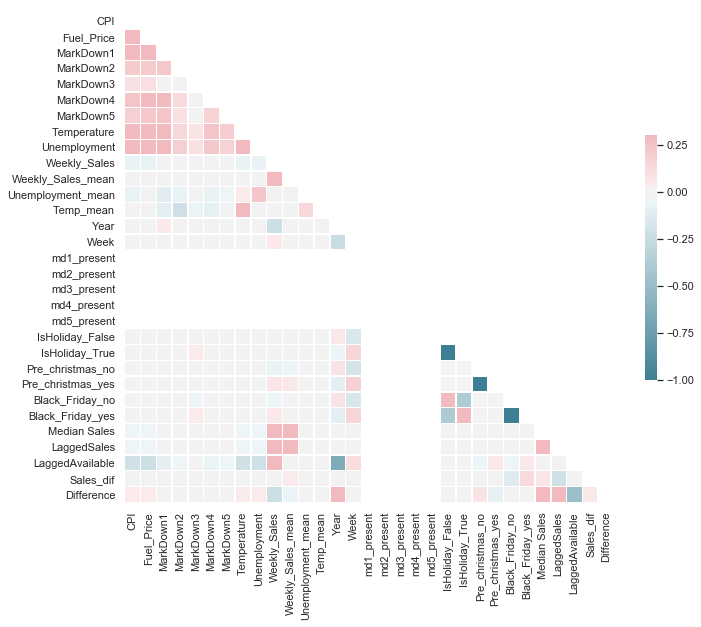

In [83]:
sns.set(style="white")

# Compute the correlation matrix
corr = df_fill.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [84]:
#Using the important variables we will require to build the model
selector = ['CPI','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Temperature','Unemployment','md1_present','md2_present','md3_present','md4_present','md5_present','IsHoliday_False','IsHoliday_True','Pre_christmas_no','Pre_christmas_yes','Black_Friday_no','Black_Friday_yes','LaggedSales','Sales_dif','LaggedAvailable']
df_fill[selector].describe()

,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Temperature,Unemployment,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
count,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000,544824.000000
mean,2.407318,0.051200,52.043454,18.143804,11.672103,20.936541,30.717216,0.892265,0.109252,0.928098,0.071902,0.988853,0.011147,0.988897,0.011103,15843.366134,-192.425280,0.761785
std,20.770490,0.417807,999.040140,689.572588,929.208371,601.458362,1182.693075,7.576901,0.944640,0.258326,0.258326,0.104988,0.104988,0.104783,0.104783,22541.433348,5958.303444,0.425991
min,0.000000,0.000000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,-7.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1750.000000,-540263.085000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2165.620000,-285.851250,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7563.040000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,19886.125000,264.475000,1.000000
max,228.976456,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,101.950000,14.313000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,693099.360000,579251.325000,1.000000


In [85]:
#Train-Test split
train=df_fill.loc[df_fill['Type']=='Train']
test=df_fill.loc[df_fill['Type']=='Test']

In [86]:
test.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
8199,0.0,2013-02-01,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,23510.49,Dept_1.0Store_12013-02-01 00:00:00IsHoliday_False,2013-01-25,23510.49,0.0,0.0,23510.49
8200,0.0,2013-02-15,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,23510.49,Dept_1.0Store_12013-02-15 00:00:00IsHoliday_False,2013-02-08,23510.49,0.0,0.0,23510.49
8201,0.0,2013-02-22,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,23510.49,Dept_1.0Store_12013-02-22 00:00:00IsHoliday_False,2013-02-15,23510.49,0.0,0.0,23510.49
8205,0.0,2013-02-08,Dept_1.0,0.0,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,...,0,1,0,37887.17,Dept_1.0Store_12013-02-08 00:00:00IsHoliday_True,2013-02-01,37887.17,0.0,0.0,37887.17
8219,0.0,2013-03-01,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,1,0,21280.40,Dept_1.0Store_12013-03-01 00:00:00IsHoliday_False,2013-02-22,21280.40,0.0,0.0,21280.40


In [87]:
# Set seed for reproducability 
np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Difference'], test_size=0.2, random_state=42)
print(X_dev.shape)
print(y_dev.shape)

(84314, 23)
(84314,)


In [88]:
#Model using Random Forest
regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)
regr.fit(X_train, y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [91]:
#Making Predictions
y_pred_random = regr.predict(X_dev)
y_dev = y_dev.to_frame()

y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.9s finished


,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,Predicted
8192,0.0,2010-02-26,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,1,0,23510.49,Dept_1.0Store_12010-02-26 00:00:00IsHoliday_False,2010-02-19,41595.55,1.0,-18085.06,4106.95,-5428.37575
8197,0.0,2012-02-17,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,1,0,23510.49,Dept_1.0Store_12012-02-17 00:00:00IsHoliday_False,2012-02-10,36988.49,1.0,-13478.00,-30549.61,-895.38825
8204,0.0,2012-02-10,Dept_1.0,0.0,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,...,1,0,37887.17,Dept_1.0Store_12012-02-10 00:00:00IsHoliday_True,2012-02-03,23510.49,1.0,14376.68,898.68,-620.73300
8218,0.0,2012-03-30,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,1,0,21280.40,Dept_1.0Store_12012-03-30 00:00:00IsHoliday_False,2012-03-23,22107.70,1.0,-827.30,-7672.46,-1822.73025
8229,0.0,2011-04-01,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,1,0,26318.08,Dept_1.0Store_12011-04-01 00:00:00IsHoliday_False,2011-03-25,20881.10,1.0,5436.98,5919.99,2550.79975


In [94]:
df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']

In [95]:
print("Medians: "+str(sum(abs(df_out['Difference']))/df_out.shape[0]))
print("Random Forest: "+str(sum(abs(df_out['Weekly_Sales']-df_out['prediction']))/df_out.shape[0]))

Medians: 1545.7406070759305
Random Forest: 1604.9437326922216


In [96]:
#Seems good.
#Training the entire data set now and making submissions
rf_model = RandomForestRegressor(n_estimators=80, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=0, warm_start=False)

#Train on data
rf_model.fit(train[selector], train['Difference'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Making final predictions

In [97]:
final_y_prediction = rf_model.predict(test[selector])

In [98]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,0,prediction
0,0.0,2013-02-01,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,23510.49,Dept_1.0Store_12013-02-01 00:00:00IsHoliday_False,2013-01-25,23510.49,0.0,0.0,23510.49,-2496.893000,26007.383000
1,0.0,2013-02-15,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,23510.49,Dept_1.0Store_12013-02-15 00:00:00IsHoliday_False,2013-02-08,23510.49,0.0,0.0,23510.49,-2496.893000,26007.383000
2,0.0,2013-02-22,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,23510.49,Dept_1.0Store_12013-02-22 00:00:00IsHoliday_False,2013-02-15,23510.49,0.0,0.0,23510.49,-2496.893000,26007.383000
3,0.0,2013-02-08,Dept_1.0,0.0,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,...,0,37887.17,Dept_1.0Store_12013-02-08 00:00:00IsHoliday_True,2013-02-01,37887.17,0.0,0.0,37887.17,-2506.214875,40393.384875
4,0.0,2013-03-01,Dept_1.0,0.0,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,21280.40,Dept_1.0Store_12013-03-01 00:00:00IsHoliday_False,2013-02-22,21280.40,0.0,0.0,21280.40,-762.010750,22042.410750


In [99]:
submission = pd.DataFrame({'id':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Dept']]).map(str)  + '_' +
                           testfile['Date'].map(str),
                          'Weekly_Sales':testfile['prediction']})

In [106]:
submission.head(10)

,id,Weekly_Sales
0,1_10_2013-02-01 00:00:00,26007.383000
1,1_10_2013-02-15 00:00:00,26007.383000
2,1_10_2013-02-22 00:00:00,26007.383000
3,1_10_2013-02-08 00:00:00,40393.384875
4,1_10_2013-03-01 00:00:00,22042.410750
5,1_10_2013-03-08 00:00:00,22042.410750
6,1_10_2013-03-15 00:00:00,22042.410750
7,1_10_2013-03-22 00:00:00,22042.410750
8,1_10_2013-03-29 00:00:00,22042.410750
9,1_10_2013-04-05 00:00:00,26938.277500


In [110]:
submission.head()

,id,Weekly_Sales
0,1_10_2013-02-01 00:00:00,26007.383000
1,1_10_2013-02-15 00:00:00,26007.383000
2,1_10_2013-02-22 00:00:00,26007.383000
3,1_10_2013-02-08 00:00:00,40393.384875
4,1_10_2013-03-01 00:00:00,22042.410750


In [101]:
submission.to_csv('submission.csv', index=False)

In [102]:
sampleSubmission=pd.read_csv('sampleSubmission.csv')

In [103]:
sampleSubmission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0
